# Airline Satisfaction Analysis

Group D: Barnali Dash, Yashasvi Kothari, Anthony Stachowski, Luke Uhrig

November 25, 2020


This data set is taken from Kaggle:

https://www.kaggle.com/teejmahal20/airline-passenger-satisfaction?select=train.csv


### Imports
Bringing in various libraries and functions needed for our analysis. Some packages may need to be installed.


In [ ]:
# Install packages that are needed:
!pip install seaborn xgboost statsmodels shap

In [ ]:
# Package imports

import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import chi2_contingency 
import shap

from matplotlib import pyplot
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.feature_selection import VarianceThreshold, RFE
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, roc_curve, plot_roc_curve, plot_confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

from sklearn.svm import SVC

from xgboost import XGBClassifier

In [ ]:
# Set up seaborn plots
sns.set(rc = {'figure.figsize': (7, 6)},
        font_scale = 1.25) # increase text size on plots (e.g., axis labels)
sns.set_style('whitegrid')

### Setup

Run the following code cells to read in and initialize the data for the analysis:

In [ ]:
# Ensure that this file is in the same folder as the Python Script:
airlineDatRaw = pd.read_csv('Airline_Satisfaction.csv', encoding = 'ISO-8859-1')

In [ ]:
# Viewing the first few rows of our data set:
airlineDatRaw.head(10)

,id,gender,customerType,age,typeOfTravel,class,flightDistance,inflightWiFiRating,depArrConvenienceRating,easeOnlineBookingRating,...,inflightEntertainmentRating,onBoardServiceRating,legRoomRating,baggageHandlingRating,checkInServiceRating,inflightServiceRating,cleanlinessRating,depDelayMinutes,arrDelayMinutes,overallSatisfaction
0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied
5,111157,Female,Loyal Customer,26,Personal Travel,Eco,1180,3,4,2,...,1,3,4,4,4,4,1,0,0.0,neutral or dissatisfied
6,82113,Male,Loyal Customer,47,Personal Travel,Eco,1276,2,4,2,...,2,3,3,4,3,5,2,9,23.0,neutral or dissatisfied
7,96462,Female,Loyal Customer,52,Business travel,Business,2035,4,3,4,...,5,5,5,5,4,5,4,4,0.0,satisfied
8,79485,Female,Loyal Customer,41,Business travel,Business,853,1,2,2,...,1,1,2,1,4,1,2,0,0.0,neutral or dissatisfied
9,65725,Male,disloyal Customer,20,Business travel,Eco,1061,3,3,3,...,2,2,3,4,4,3,2,0,0.0,neutral or dissatisfied


In [ ]:
# Number of observations and features:
airlineDatRaw.shape

(103904, 24)

In [ ]:
# Data types of each feature:
airlineDatRaw.dtypes

id                               int64
gender                          object
customerType                    object
age                              int64
typeOfTravel                    object
class                           object
flightDistance                   int64
inflightWiFiRating               int64
depArrConvenienceRating          int64
easeOnlineBookingRating          int64
gateLocationRating               int64
foodDrinkRating                  int64
onlineBoardingRating             int64
seatComfortRating                int64
inflightEntertainmentRating      int64
onBoardServiceRating             int64
legRoomRating                    int64
baggageHandlingRating            int64
checkInServiceRating             int64
inflightServiceRating            int64
cleanlinessRating                int64
depDelayMinutes                  int64
arrDelayMinutes                float64
overallSatisfaction             object
dtype: object

### Data Description:

Initial features:

*id*: This is a unique id for each customer, basically an index

1. *gender*: Gender of the passengers (Female, Male)
2. *csutomerType*: The customer type (Loyal customer, disloyal customer)
3. *age*: The actual age of the passengers
4. *typeOfTravel*: Purpose of the flight of the passengers (Personal Travel, Business Travel)
5. *class*: Travel class in the plane of the passengers (Business, Eco, Eco Plus)
6. *flightDistance*: The flight distance of this journey
7. *inflightWiFiRating*: Satisfaction level of the inflight wifi service (0:Not Applicable;1-5)
8. *depArrConvenienceRating*: Satisfaction level of Departure/Arrival time convenient
9. *easeOnlineBookingRating*: Satisfaction level of online booking
10. *gateLocationRating*: Satisfaction level of Gate location
11. *foodDrinkRating*: Satisfaction level of Food and drink
12. *onlineBoardingRating*: Satisfaction level of online boarding
13. *seatComfortRating*: Satisfaction level of Seat comfort
14. *inflightEntertainmentRating*: Satisfaction level of inflight entertainment
15. *onBoardServiceRating*: Satisfaction level of On-board service
16. *legRoomRating*: Satisfaction level of Leg room service
17. *baggageHandlingRating*: Satisfaction level of baggage handling
18. *checkInServiceRating*: Satisfaction level of Check-in service
19. *inflightServiceRating*: Satisfaction level of inflight service
20. *cleanlinessRating*: Satisfaction level of Cleanliness
21. *depDelayMinutes*: Minutes delayed when departure
22. *arrDelayMinutes*: Minutes delayed when Arrival

**Target Variable** - *overallSatisfaction*: Airline satisfaction level(Satisfaction, neutral or dissatisfaction)

### Initial Data Prep

##### Recode Target Variable:

In [ ]:
# Recode target variable so that two levels are easier to work with: High (satisfied) and Low (neutral or dissatisfied)
textMatch = airlineDatRaw.overallSatisfaction.str.contains('neutral')

airlineDatRaw['overallSatisfaction'] = np.where(textMatch, 'Low', 'High')

airlineDatRaw.groupby('overallSatisfaction').size()

overallSatisfaction
High    45025
Low     58879
dtype: int64

##### Feature Rating of 0
As pointed out above, the presence of 0 in one of the Rating Features indicates that the feature was not applicable.

We want to examine how many observations involve these cases.  From a business perspective, the lack of a rating for one of the variables could mean that the customer did not have access to what was being rated, for some reason chose not to rate it, or did not think it was relevant to their satisfaction rating.  Due to the uncertainty around why a 0 might be present, it might be best to remove these from the data set before analyzing and building our models.  However, if this is a sizable portion of our data set (e.g. more than 10%), we may need to retain these and determine a different way to handle them.

In [ ]:
column_names_drop = ['overallSatisfaction','age','flightDistance','depDelayMinutes','arrDelayMinutes','id']
df = airlineDatRaw.drop(columns = column_names_drop).select_dtypes(include = ['int64']) 
round( (len(df[df.all(1) == 0]))/len(airlineDatRaw),3)*100

#7.9% of the dataset has ratings == 0, so we can drop these as they fall below a 10% threshold of the raw data

# airlineDatRaw = airlineDatRaw[airlineDatRaw.all(1)!=0]

7.9

In [ ]:
# Drop rows where at least one rating has a zero:

ratingNames = ['inflightWiFiRating', 'depArrConvenienceRating', 'easeOnlineBookingRating',
                'gateLocationRating', 'foodDrinkRating', 'onlineBoardingRating',
                'seatComfortRating', 'inflightEntertainmentRating', 'onBoardServiceRating',
                'legRoomRating', 'baggageHandlingRating', 'checkInServiceRating',
                'inflightServiceRating', 'cleanlinessRating']

for rating in ratingNames:
    airlineDatRaw = airlineDatRaw[airlineDatRaw[rating] != 0]

In [ ]:
# Checking to make sure rows are removed:
column_names_drop = ['overallSatisfaction','age','flightDistance','depDelayMinutes','arrDelayMinutes','id']
df = airlineDatRaw.drop(columns = column_names_drop).select_dtypes(include = ['int64']) 
round( (len(df[df.all(1) == 0]))/len(airlineDatRaw),3)*100

0.0

##### Checking for Missing Data:

Analyze our data set for missing values. If the amount missing is very small, it might be best to remove these observations here before moving into visualizations and model building.

In [ ]:
# Check for missing data:
round(1 - len(airlineDatRaw.dropna())/len(airlineDatRaw), 3)

0.003

In [ ]:
# Columns with missing data

round(airlineDatRaw.isna().sum()/len(airlineDatRaw), 3)

id                             0.000
gender                         0.000
customerType                   0.000
age                            0.000
typeOfTravel                   0.000
class                          0.000
flightDistance                 0.000
inflightWiFiRating             0.000
depArrConvenienceRating        0.000
easeOnlineBookingRating        0.000
gateLocationRating             0.000
foodDrinkRating                0.000
onlineBoardingRating           0.000
seatComfortRating              0.000
inflightEntertainmentRating    0.000
onBoardServiceRating           0.000
legRoomRating                  0.000
baggageHandlingRating          0.000
checkInServiceRating           0.000
inflightServiceRating          0.000
cleanlinessRating              0.000
depDelayMinutes                0.000
arrDelayMinutes                0.003
overallSatisfaction            0.000
dtype: float64

In [ ]:
# Remove missing rows instead of imputing due to the small number of cases.:

airlineDatRaw = airlineDatRaw.dropna()

round(1 - len(airlineDatRaw.dropna())/len(airlineDatRaw), 3)

# If imputation would have been needed, we would have waited to do this until the training set was split from the raw data in order not to bias our testing set.

0.0

In [ ]:
# Number of observations and features:
airlineDatRaw.shape

(95415, 24)

Our Initial data set had 103,904 rows and with removing observations where one of the rating variables was 0 or there was missing data, we are now down to 95,415.  This was a removal of 8,489 records, which is less than 10.0% of the initial data set and therefore should not introduce sample size concerns.

In [ ]:
#Number of Unique Customers
display(airlineDatRaw.id.nunique(),airlineDatRaw.id.nunique()==len(airlineDatRaw))

95415

True

Each customer survey originates from a unique customer every time.

### Data Analysis and Visualizations:


##### Variable Creation for Visualization

In [ ]:
# Variable 1 (plotDat)

# Building compiled information for age, type of travel, and airplane class to see impact on target variable


# Creating plotting variable based on certain aspects of the customer:
plotDat = (airlineDatRaw.
            assign(roundedAge = round(airlineDatRaw.age, -1)).
            groupby(['roundedAge', 'typeOfTravel','class']).
            apply(lambda x: len(x.overallSatisfaction[x.overallSatisfaction == "High"])/len(x.overallSatisfaction)).
                reset_index().
                rename(columns = {0: 'proportionHighOverallSatisfaction'})           
            )


In [ ]:
# Variable 2 (plotDat1)

# Compiling information to examine how flight distance, type of travel, and delays (departure or arrival) influence the target variable

# Creating plotting variable based on certain aspects of the flight journey
plotDat1 = (airlineDatRaw.
            assign(adjDistance = round(airlineDatRaw.flightDistance, -2),
                    delay = np.where((airlineDatRaw.depDelayMinutes > 0) | (airlineDatRaw.arrDelayMinutes.astype('int64') > 0),"Y","N")).
            groupby(['adjDistance', 'delay', 'typeOfTravel']).
            apply(lambda x: len(x.overallSatisfaction[x.overallSatisfaction == "High"])/len(x.overallSatisfaction)).
                reset_index().
                rename(columns = {0: 'proportionHighOverallSatisfaction'})
            )

In [ ]:
# Variable 3 (plotDat2):

# Grouping rating variables into "high" and "low" categories in order to determine possible relationships with target variable

# Placing rating variables into two categories for visualizations
plotDat2 = (airlineDatRaw.
            assign(adjInflightWiFiRating = np.where(airlineDatRaw.inflightWiFiRating >= 4, "High","Low"),
                    adjDepArrConvenienceRating = np.where(airlineDatRaw.depArrConvenienceRating >= 4, "High","Low"),
                    adjEaseOnlineBookingRating = np.where(airlineDatRaw.easeOnlineBookingRating >= 4, "High","Low"),
                    adjGateLocationRating = np.where(airlineDatRaw.gateLocationRating >= 4, "High","Low"),
                    adjFoodDrinkRating = np.where(airlineDatRaw.foodDrinkRating >= 4, "High","Low"),
                    adjOnlineBoardingRating = np.where(airlineDatRaw.onlineBoardingRating >= 4, "High","Low"),
                    adjSeatComfortRating = np.where(airlineDatRaw.seatComfortRating >= 4, "High","Low"),
                    adjInflightEntertainmentRating = np.where(airlineDatRaw.inflightEntertainmentRating >= 4, "High","Low"),
                    adjOnBoardServiceRating = np.where(airlineDatRaw.onBoardServiceRating >= 4, "High","Low"),
                    adjLegRoomRating = np.where(airlineDatRaw.legRoomRating >= 4, "High","Low"),
                    adjBaggageHandlingRating = np.where(airlineDatRaw.baggageHandlingRating >= 4, "High","Low"),
                    adjCheckInServiceRating = np.where(airlineDatRaw.checkInServiceRating >= 4, "High","Low"),
                    adjInflightServiceRating = np.where(airlineDatRaw.inflightServiceRating >= 4, "High","Low"),
                    adjCleanlinessRating = np.where(airlineDatRaw.cleanlinessRating >= 4, "High","Low")
                    )
            )

#### Visualization 1 (Using Iterative Process)

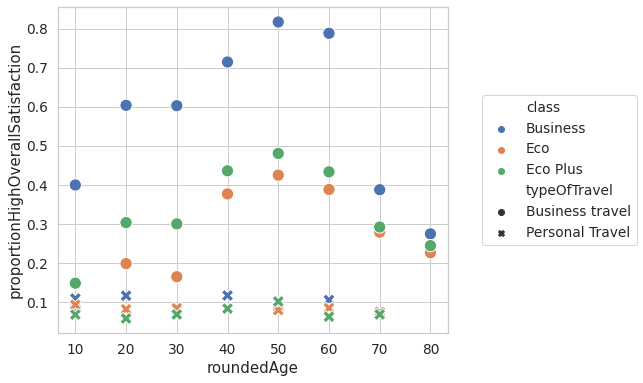

In [ ]:
# Initial Attempt at Scatter Plot Using Variables from plotDat

p = sns.scatterplot(
    x = 'roundedAge',
    y = 'proportionHighOverallSatisfaction',
    s = 150,
    style = 'typeOfTravel',
    hue = 'class',
    data = plotDat)

p.legend(loc = 'center right', bbox_to_anchor = (1.5, 0.5), ncol = 1) # move legend outside of plot

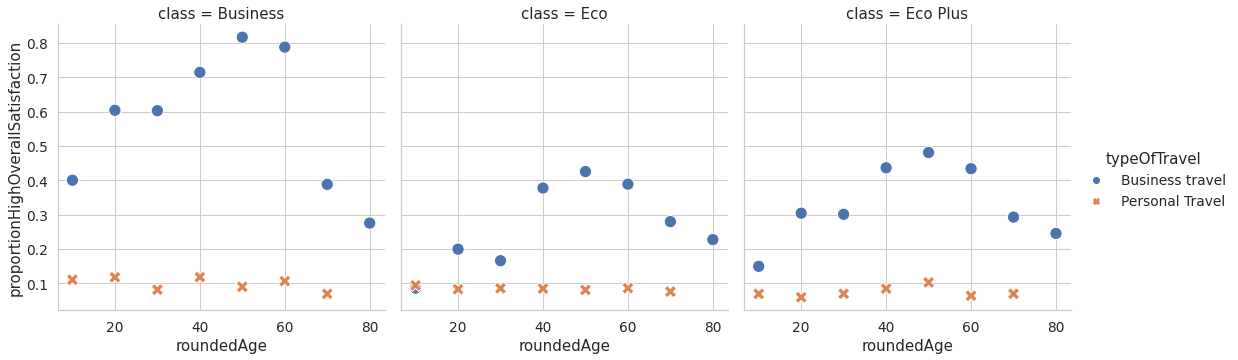

In [ ]:
# Attempt at replotting above graph with Class Faceted Out
sns.relplot(
    x = 'roundedAge',
    y = 'proportionHighOverallSatisfaction',
    s = 150,
    style = 'typeOfTravel',
    hue = 'typeOfTravel',
    col = 'class',
    kind = 'scatter',
    data = plotDat)

# There is much more variability occuring within Business Travel

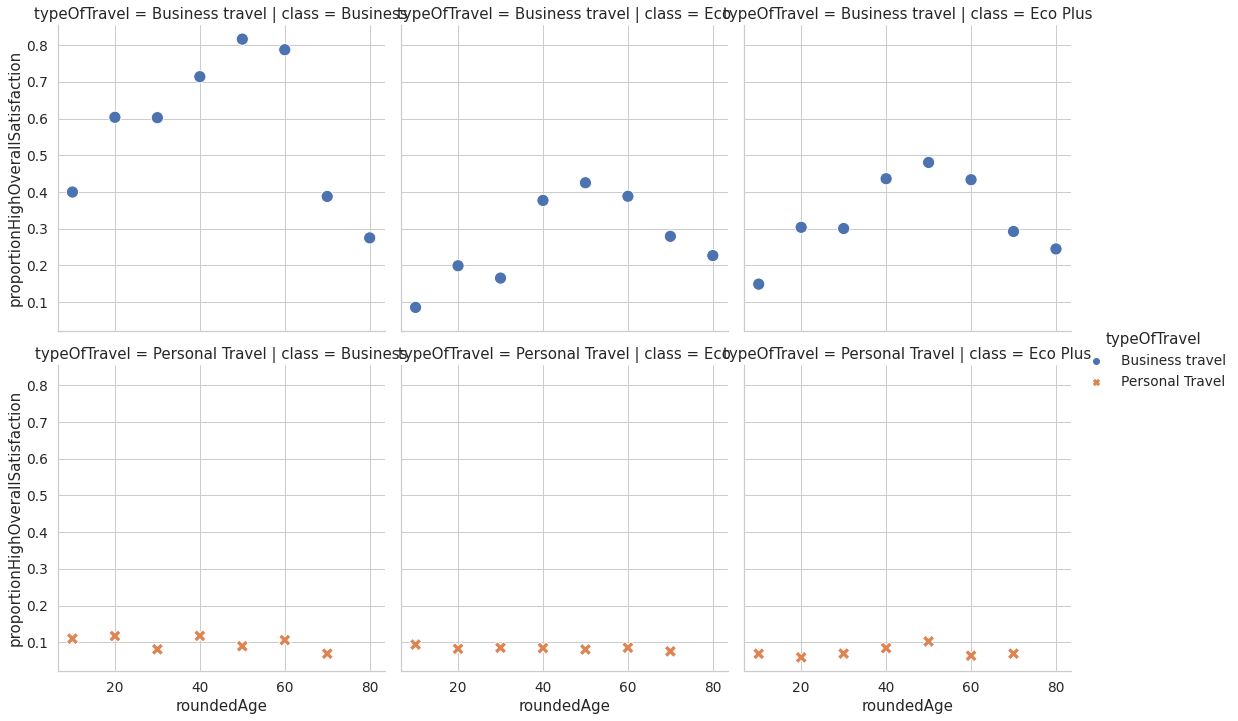

In [ ]:
# Attempt at replotting above graph with Type of Travel also Faceted Out
sns.relplot(
    x = 'roundedAge',
    y = 'proportionHighOverallSatisfaction',
    s = 150,
    style = 'typeOfTravel',
    hue = 'typeOfTravel',
    col = 'class',
    row = 'typeOfTravel',
    kind = 'scatter',
    data = plotDat)



**Observations from above graphs:**

The above scatterplots show that there are some strong differences in the likelihood of a high rating between those who are traveling for business versus those who are traveling for personal reasons.  Business travelers are much more likely to give a high overall rating.  Business travelers also see some stronger differences by age versus personal travelers.

There is also a notable difference between traveling class that becomes even more notable when broken out between Business and Personal reasons for traveling.  Among Business travelers, the ones who travel in Business class are more likely to give a high rating versus those who travel in Eco or Eco Plus.

### Visualization 2 (Iterative Process)

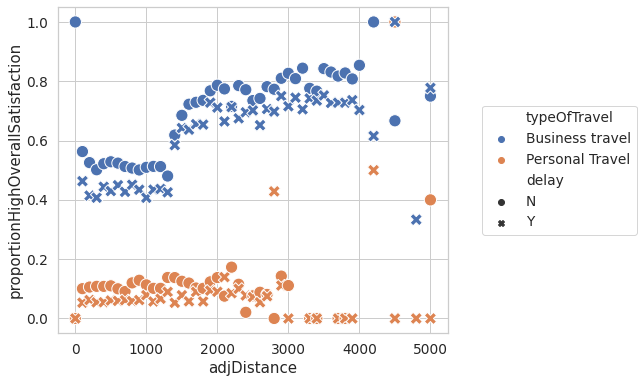

In [ ]:
# Scatter Plot Using Variables from plotDat1

p1 = sns.scatterplot(
    x = 'adjDistance',
    y = 'proportionHighOverallSatisfaction',
    s = 150,
    style = 'delay',
    hue = 'typeOfTravel',
    data = plotDat1)

p1.legend(loc = 'center right', bbox_to_anchor = (1.5, 0.5), ncol = 1) # move legend outside of plot

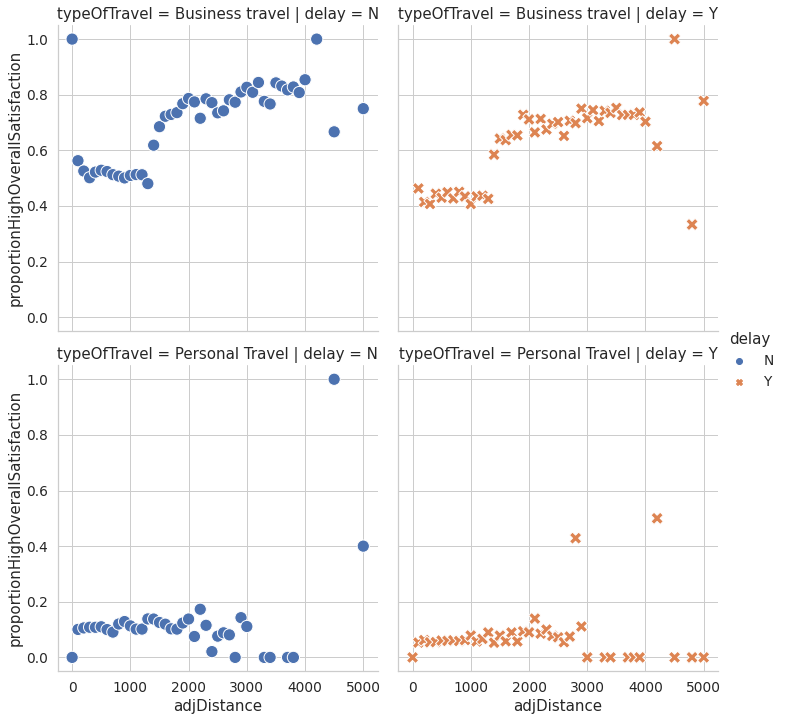

In [ ]:
# Re-plot with variables faceted out:

sns.relplot(
    x = 'adjDistance',
    y = 'proportionHighOverallSatisfaction',
    s = 150,
    style = 'delay',
    hue = 'delay',
    col = 'delay',
    row = 'typeOfTravel',
    kind = 'scatter',
    data = plotDat1)

**Observations from above graphs:**

For business travelers, ratings are typically higher for flights that are not delayed.
Within this category of travelers, longer flights typically have higher ratings, but it almost appears to be stepwise around 2,000 distance units.

For personal travelers, ratings are also typically higher for flights that are not delayed.
There is not as much of a notable change in ratings between those delayed and not delayed over the flight distance.
There actually appears to be similar satisfaction for personal travelers over long distances, but these may make up a smaller portion of the data set.

### Visualization 3

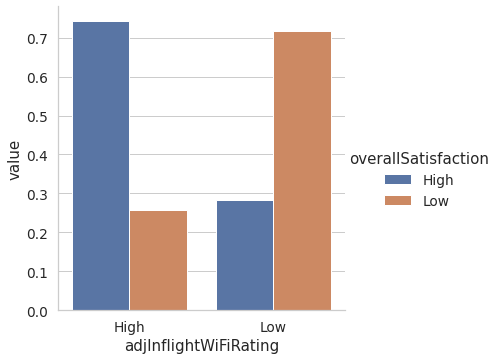

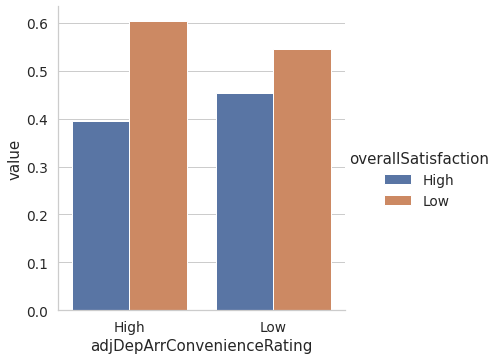

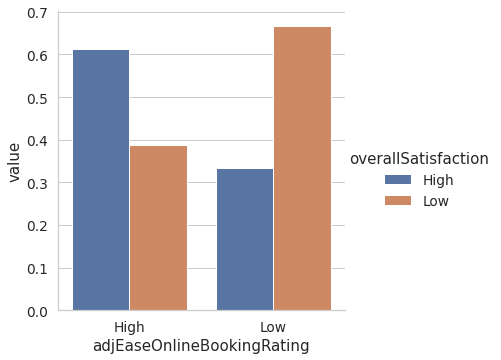

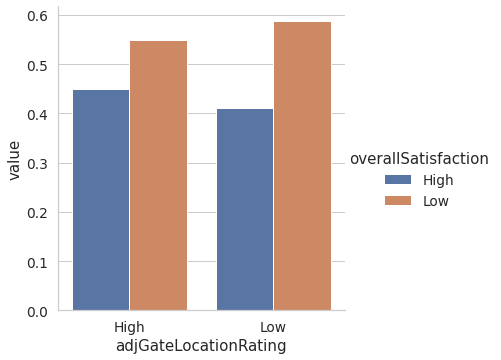

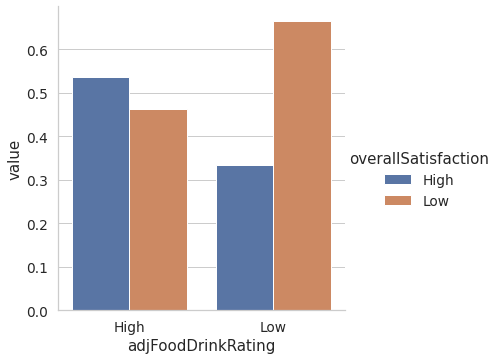

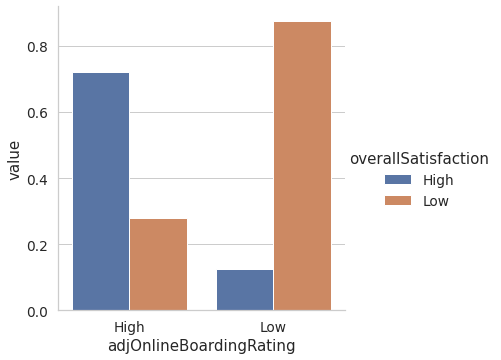

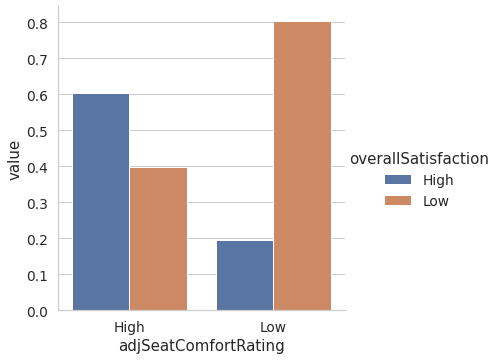

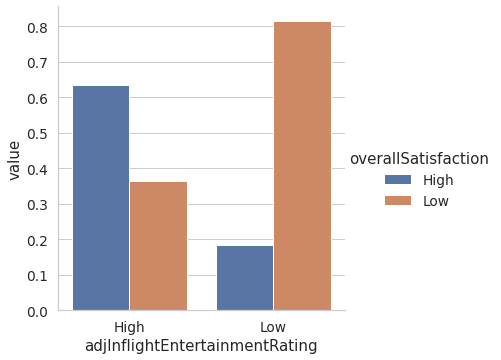

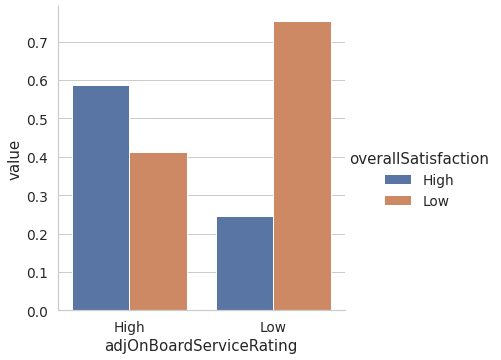

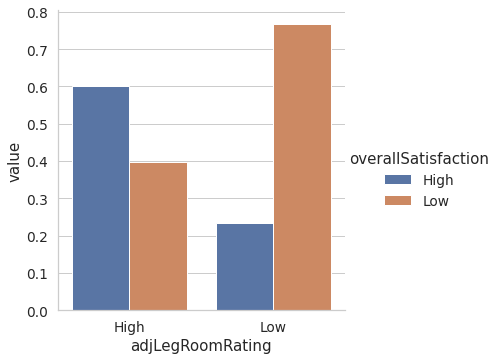

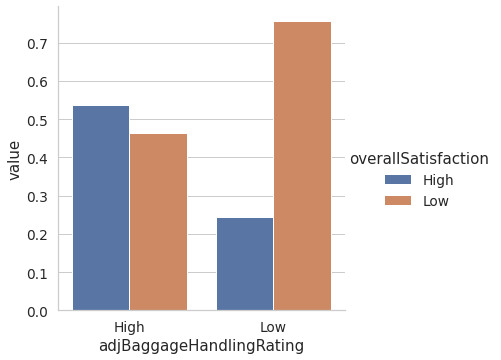

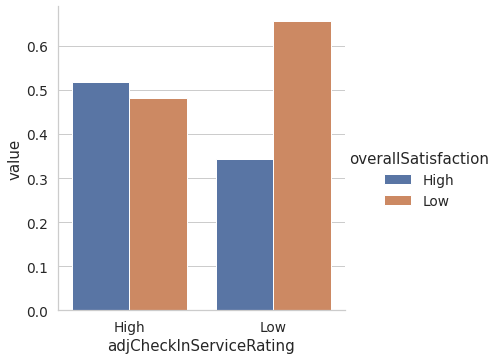

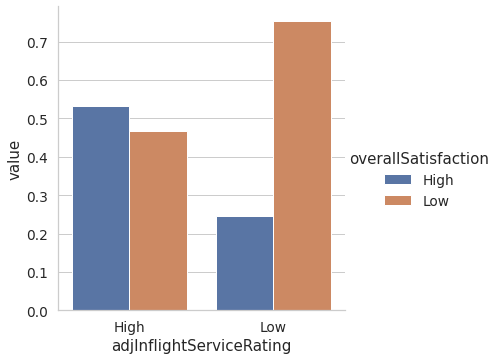

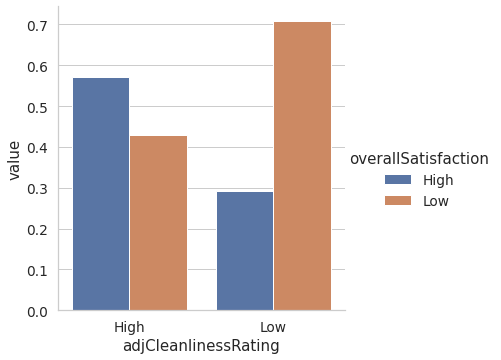

In [ ]:
# Visualizing Rating Variables' impact on Target Variable by examining percentages:
plotCols = ['adjInflightWiFiRating', 'adjDepArrConvenienceRating', 'adjEaseOnlineBookingRating',
            'adjGateLocationRating', 'adjFoodDrinkRating', 'adjOnlineBoardingRating',
            'adjSeatComfortRating', 'adjInflightEntertainmentRating', 'adjOnBoardServiceRating',
            'adjLegRoomRating', 'adjBaggageHandlingRating', 'adjCheckInServiceRating',
            'adjInflightServiceRating', 'adjCleanlinessRating']

for eachCol in plotCols:
    plotVar = eachCol

    plotd = pd.crosstab(plotDat2[plotVar], plotDat2.overallSatisfaction).apply(lambda r: r/r.sum(), axis = 1).reset_index()
    plotd

    #sns.barplot(x = plotd.index, y = plotd.values)
    plotd2 = pd.melt(plotd, id_vars = [plotVar])
    #plotd.reset_index()

    display(sns.catplot(x = plotVar, y = 'value', data = plotd2, kind = 'bar', hue = 'overallSatisfaction'))

### Visualization 4

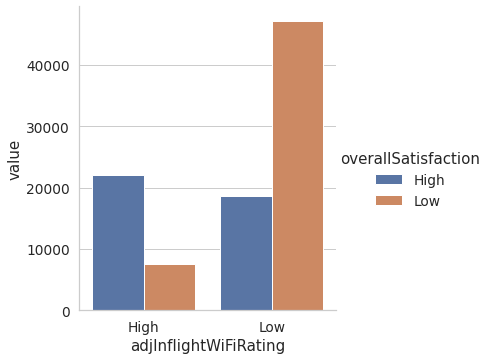

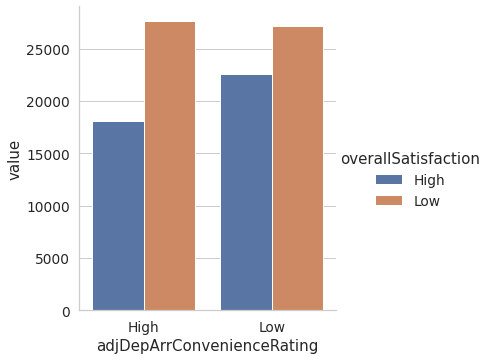

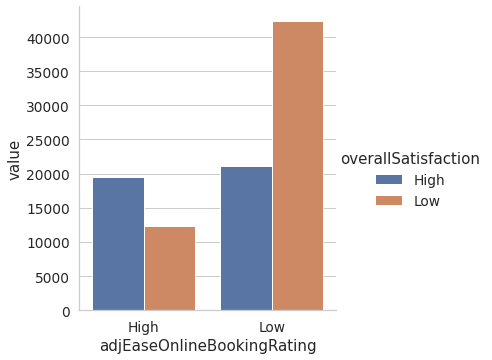

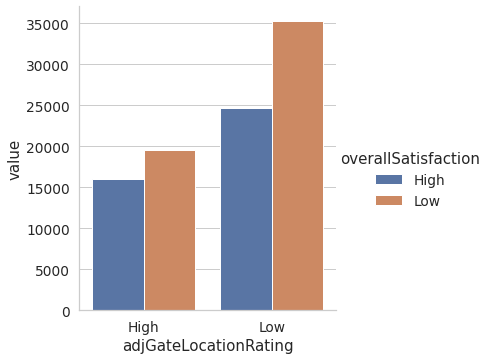

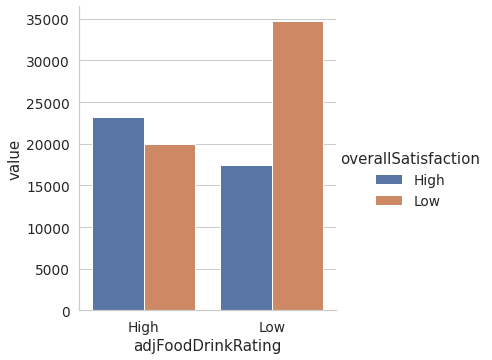

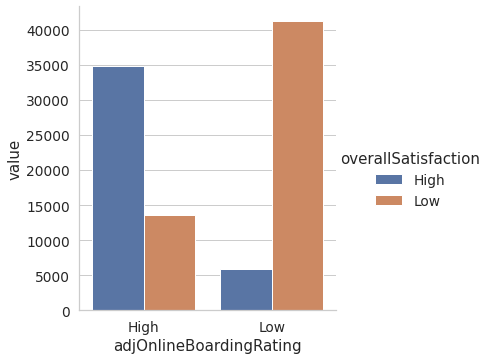

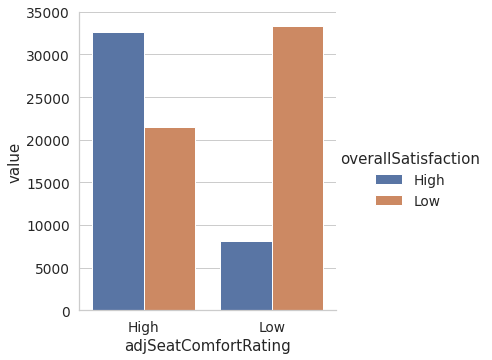

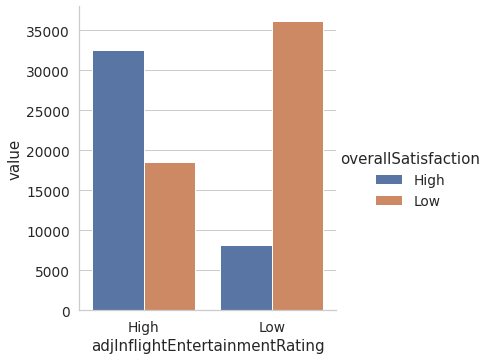

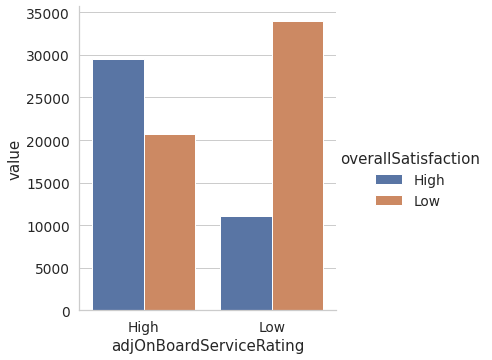

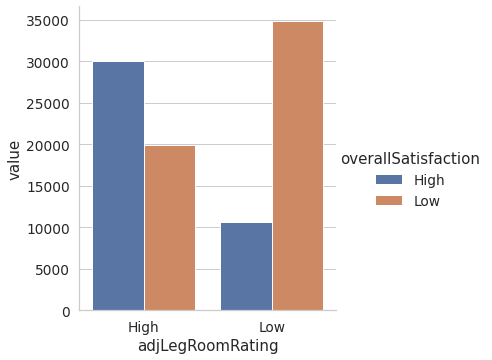

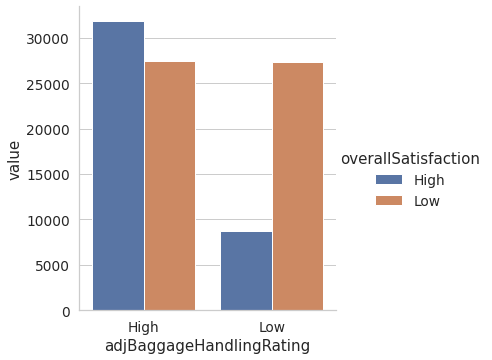

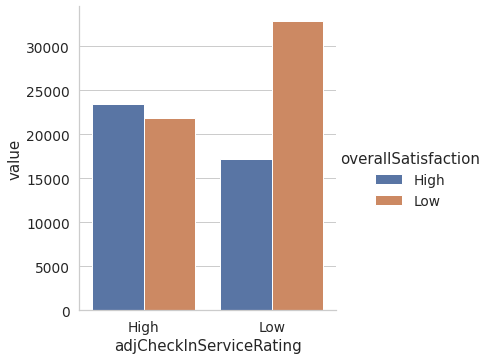

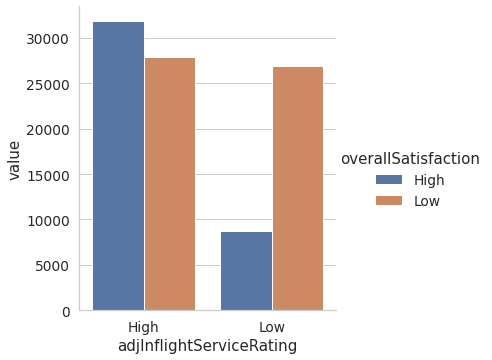

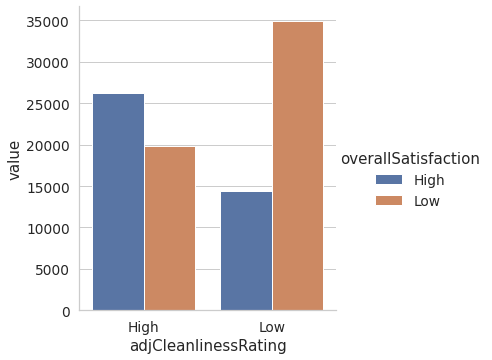

In [ ]:
# Visualizing Rating Variables' impact on Target Variable by examining counts:
for eachCol1 in plotCols:
    plotVar1 = eachCol1

    plotd1 = pd.crosstab(plotDat2[plotVar1], plotDat2.overallSatisfaction).apply(lambda r: r, axis = 1).reset_index()
    plotd1

    #sns.barplot(x = plotd.index, y = plotd.values)
    plotd3 = pd.melt(plotd1, id_vars = [plotVar1])
    #plotd.reset_index()

    display(sns.catplot(x = plotVar1, y = 'value', data = plotd3, kind = 'bar', hue = 'overallSatisfaction'))

**Observations for Visualizations 3 and 4:**

Visualizations three and four look at the distribution and count for each of the variables that include a rating (1-5) and their relationship to the target variable.  For simplicity, the variables with ratings were coded as 'low' (rating of 1-3) and 'high'.

For these visualizations we would be looking for rating variables where the distribiton for low and high is opposite and there are enough observations in each group to have the potential to be statistically significant.  Based on reviewing these, the following rating variables may prove to be useful in predicting the target variable:
* Online Boarding Rating (strong percentage differences and significant count differences)
* Inflight Entertainment Rating (pretty strong difference across both the low and high rating of the IV and DV)

These graphs also reveal variables based on ratings that might be less useful because of distributions that are not starkly different:
* Departure-Arrival Convenience Rating
* Gate Location Rating
* Food and Drink Rating
* Check-In Service Rating
* Cleanliness Rating

There are likely other desciptive information that can be drawn from these variables, but this provides some initial insights into distribution effects by the variables that include ratings.

### Visualization 5:

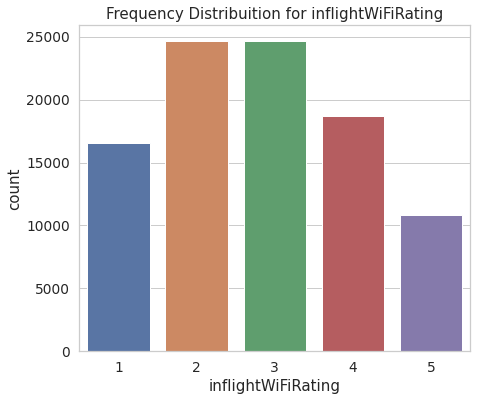

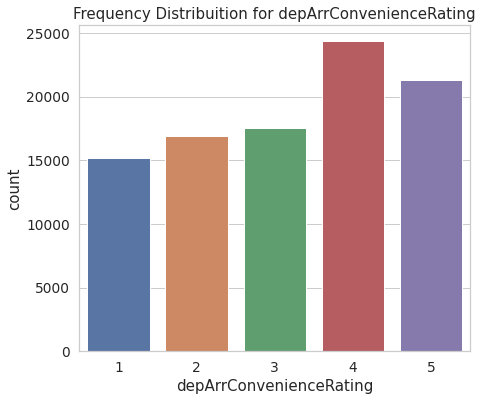

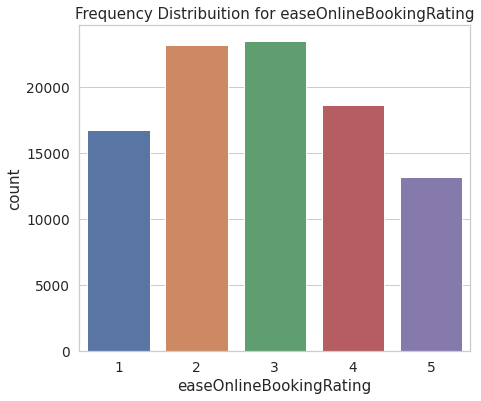

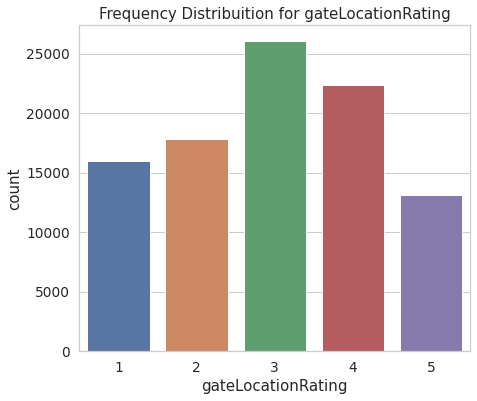

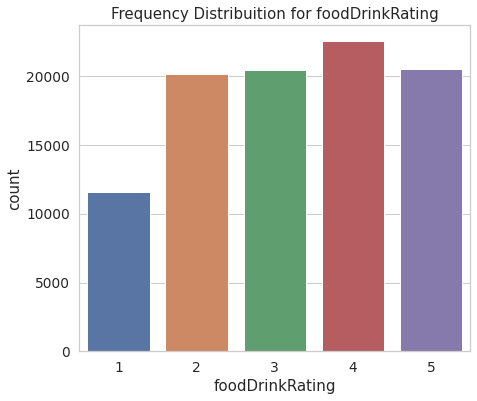

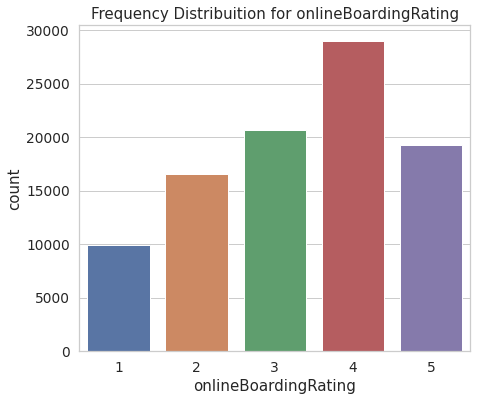

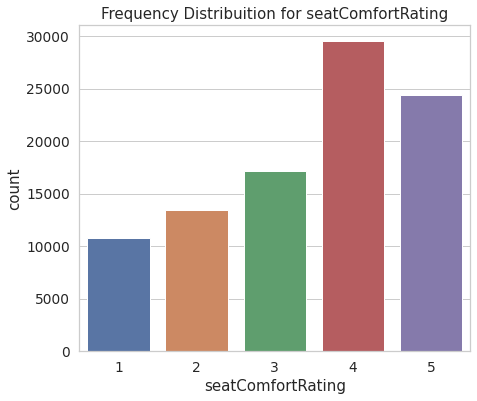

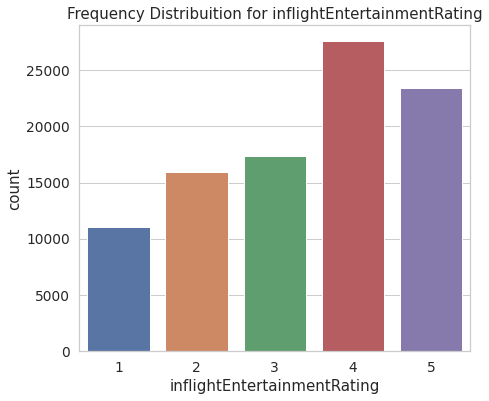

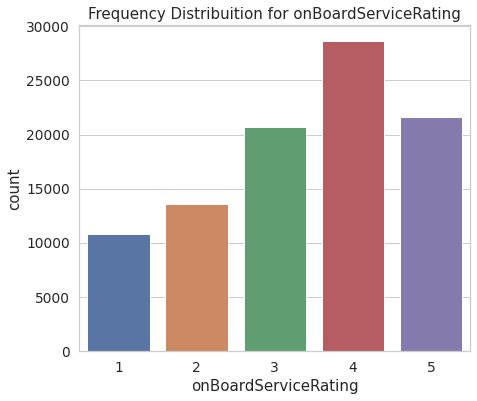

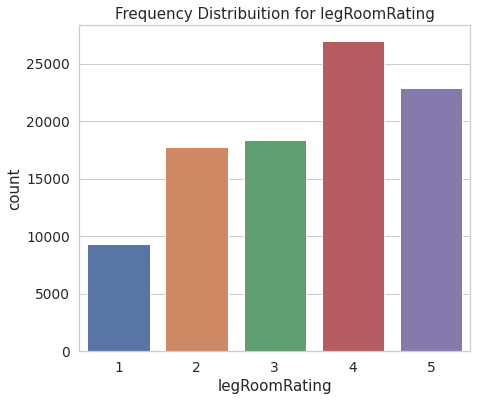

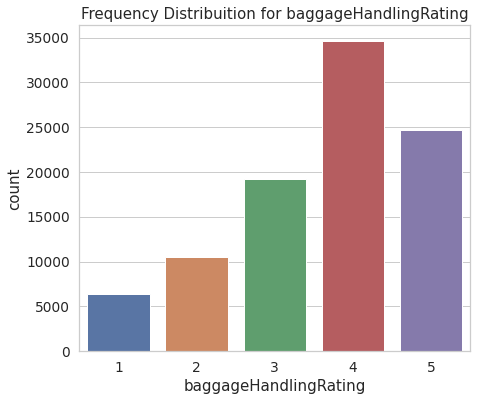

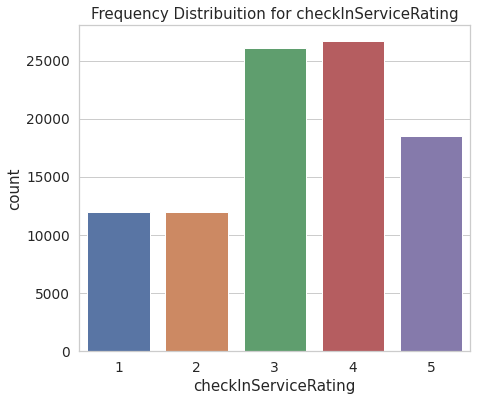

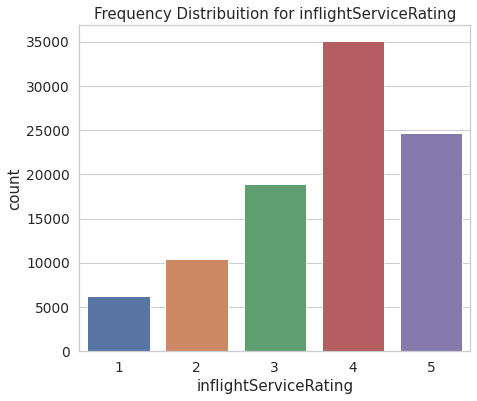

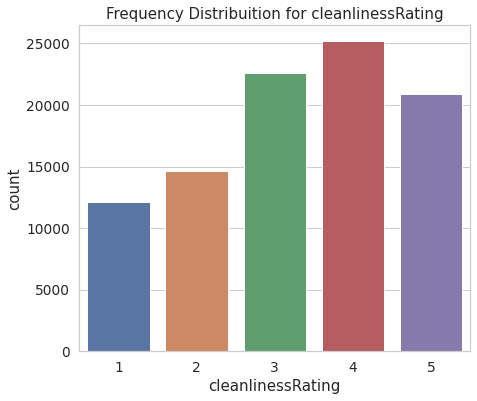

In [ ]:
# Plotting the distribution of each of the rating variables:
for eachName in ratingNames:
    xVar = eachName
    plt.figure(eachName)
    sns.countplot(x = xVar, data = airlineDatRaw).set_title('Frequency Distribuition for '+ eachName)


**Observations on above graphs:**

These comments will reflect differences in the distributions between the ratings of 1-5. Each of these particular categories would need to be analyzed in greater detail to determine specific aspects of these categories that might be able to be changed to increase individual variable ratings.

* In-Flight WiFi Rating - distribution is more skewed towards low side of spectrum; improvements are likely needed here especially if this plays a role in target variable.
* Departure and Arrival Convenience Rating - more skewed towaards high side of spectrum; airline looks to be doing a decent job here from customers' perspective.
* Ease of Online Booking - distribution is more skewed towards low side of spectrum; likely need to make online booking process easier
* Gate Location Rating - more neutral (around 3); airline may have little control on this
* Food & Drink Rating - relatively stable results across 2-5; likely need some improvement here, but food & drink ratings are heavily subjective to individual tastes; may need to increase food and drink quality
* Online Boarding Rating - skewed more high; looks like customers are generally pleased with this process
* Seat Comfort Rating - skewed high; customers who responded seem please overall with the airline's seat comfort
* In-Flight Entertainment Rating - skewed high; customers seem generally pleased with this part of their airline trip
* On-Board Service Rating - skewed more to high side of rating; may be able to make slight improvements here if further details are gathered
* Leg-Room Rating - skewed more toward high side of rating; there could be some differences occurring here based on the class the customer sat in that should be examined in greater detail
* Baggage Handling Rating - skewed high; customers generally seem pleased with how their bags are handled by the airline
* Check-In Service Rating - skewed high, but not as drastically as baggage handling rating; more people were neutral here so there is room for improvement here that the airline could likely influence
* In-Flight Service Rating - skewed high; airline looks to be doing a good job on in-flight service
* Cleanliness Rating - skewed more toward high side of the rating; it seems like people are generally pleased with the cleanliness of the airplane

### Visualization 6:

Text(0.5, 1.0, 'Satisfaction Count')

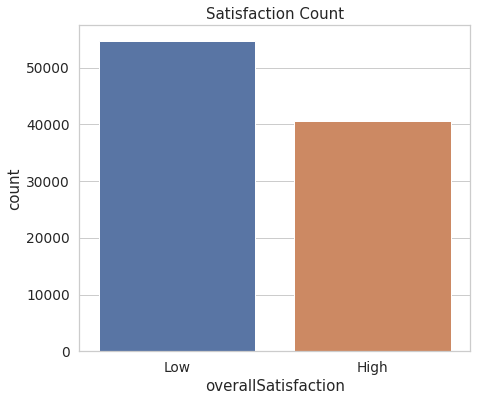

In [ ]:
#Target Variable Count Plot
sns.countplot(x = 'overallSatisfaction',
            data = airlineDatRaw).set_title('Satisfaction Count')

In [ ]:
#Target Variable Count
airlineDatRaw.groupby('overallSatisfaction').size()

overallSatisfaction
High    40638
Low     54777
dtype: int64

### Visualization 7

<AxesSubplot:xlabel='overallSatisfaction', ylabel='age'>

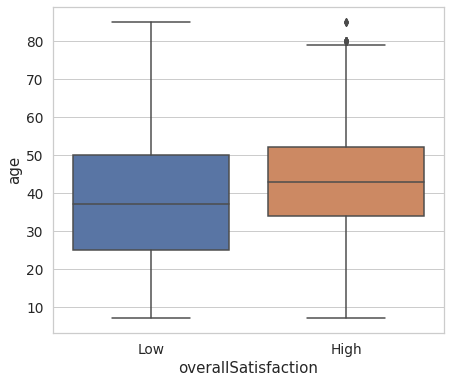

In [ ]:
#Box Plot - Age

sns.boxplot(x = 'overallSatisfaction', 
            y = 'age',
            data = airlineDatRaw)

<AxesSubplot:xlabel='overallSatisfaction', ylabel='flightDistance'>

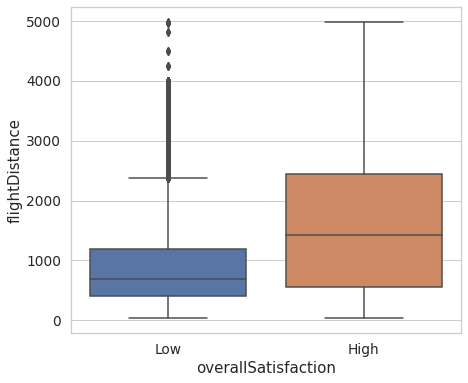

In [ ]:
#Box Plot - Flight Distance

sns.boxplot(x = 'overallSatisfaction', 
            y = 'flightDistance',
            data = airlineDatRaw)

<AxesSubplot:xlabel='overallSatisfaction', ylabel='depDelayMinutes'>

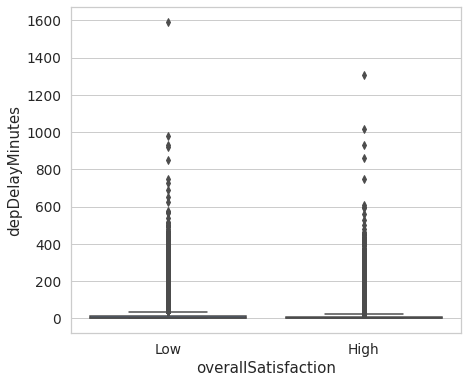

In [ ]:
#Box Plot - Departure Delay Time in Minutes

sns.boxplot(x = 'overallSatisfaction', 
            y = 'depDelayMinutes',
            data = airlineDatRaw)

<AxesSubplot:xlabel='overallSatisfaction', ylabel='arrDelayMinutes'>

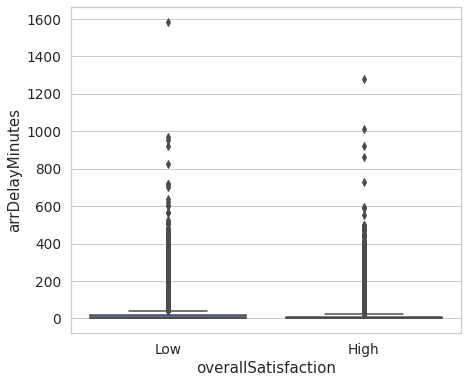

In [ ]:
#Box Plot - Arrival Delay Time in Minutes

sns.boxplot(x = 'overallSatisfaction', 
            y = 'arrDelayMinutes',
            data = airlineDatRaw)

### Visualization 8:

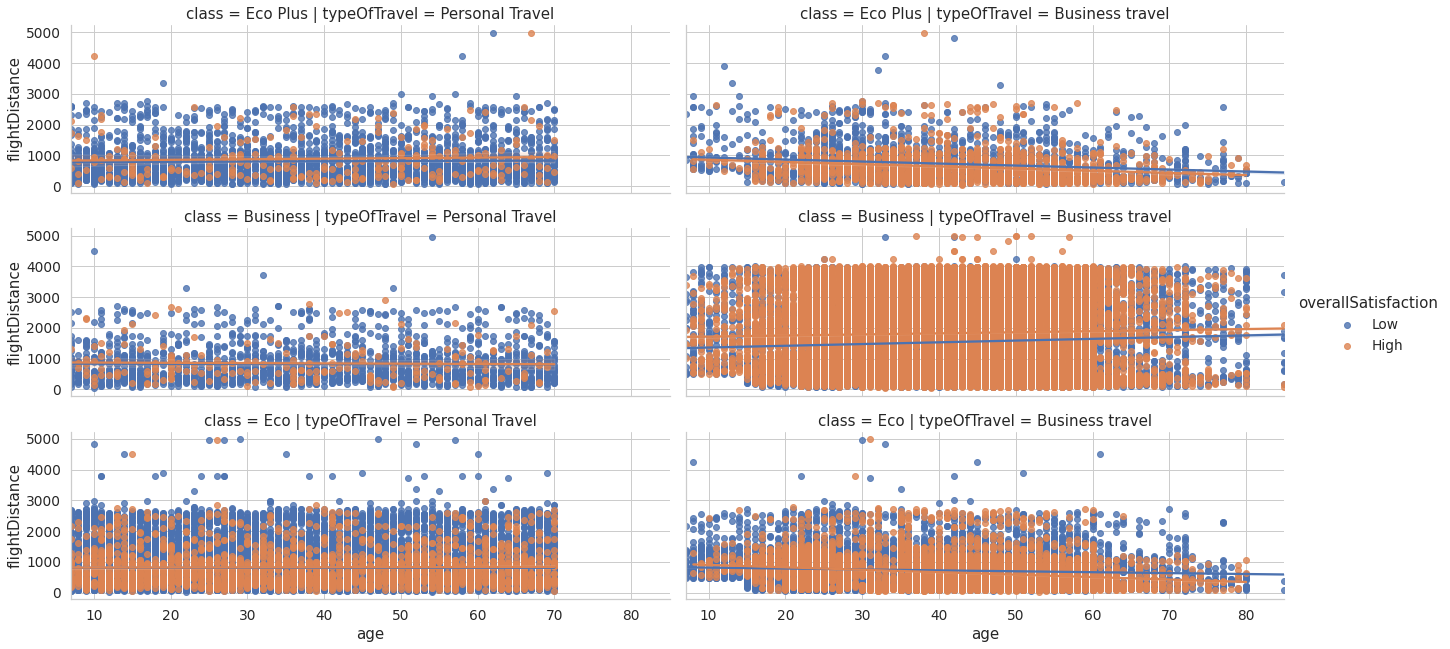

In [ ]:
#Liniear Plots - Age with Flight Distance
#add alpha to points
#remove points
#sample points down
p1 = sns.lmplot(x = 'age', 
                y = 'flightDistance', 
                hue = 'overallSatisfaction', 
                col = 'typeOfTravel',
                row= 'class',
                data = airlineDatRaw, 
                legend_out=True,
                aspect= 3,
                height=3)

### Visualization 9:

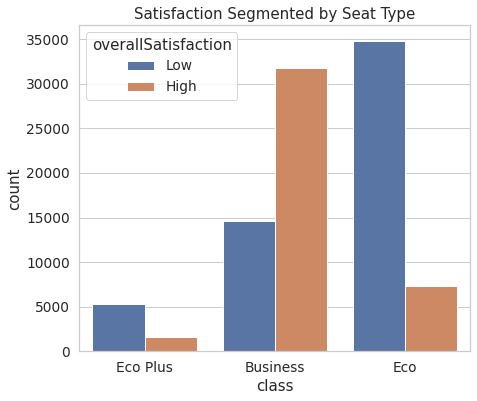

In [ ]:
p9 = (sns.countplot(
    x = 'class', 
    data = airlineDatRaw, 
    hue = 'overallSatisfaction').
    set_title('Satisfaction Segmented by Seat Type'))


In [ ]:
#running chisq tests to test for association (categorical variables)

for column in airlineDatRaw.columns: 
    x1 = airlineDatRaw.overallSatisfaction
    x2 = airlineDatRaw[column]
        #need a contigency table
    contingency_table = pd.crosstab(x1,x2)
    stat, p, dof, expected = chi2_contingency(contingency_table) 
    # interpret p-value 
    alpha = 0.05
    print(str(column) + ": p value is " + str(p)) 
    if p <= alpha: 
        print('Dependent (reject H0)') 
    else: 
        print('Independent (H0 holds true)') 


id: p value is 0.4984779261027721
Independent (H0 holds true)
gender: p value is 9.886475444439007e-05
Dependent (reject H0)
customerType: p value is 0.0
Dependent (reject H0)
age: p value is 0.0
Dependent (reject H0)
typeOfTravel: p value is 0.0
Dependent (reject H0)
class: p value is 0.0
Dependent (reject H0)
flightDistance: p value is 0.0
Dependent (reject H0)
inflightWiFiRating: p value is 0.0
Dependent (reject H0)
depArrConvenienceRating: p value is 6.767806193305036e-105
Dependent (reject H0)
easeOnlineBookingRating: p value is 0.0
Dependent (reject H0)
gateLocationRating: p value is 0.0
Dependent (reject H0)
foodDrinkRating: p value is 0.0
Dependent (reject H0)
onlineBoardingRating: p value is 0.0
Dependent (reject H0)
seatComfortRating: p value is 0.0
Dependent (reject H0)
inflightEntertainmentRating: p value is 0.0
Dependent (reject H0)
onBoardServiceRating: p value is 0.0
Dependent (reject H0)
legRoomRating: p value is 0.0
Dependent (reject H0)
baggageHandlingRating: p value 

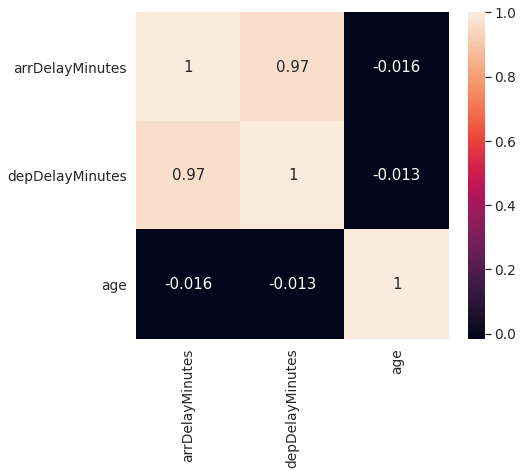

In [ ]:
#correlation matrix for continuous variables 
#arrival and departure times are highly correlated 
data = airlineDatRaw[['arrDelayMinutes','depDelayMinutes','age']]
corrMatrix=data.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

In [ ]:
#ANOVA for arrDelayMinutes 
import scipy.stats as stats
x1 = airlineDatRaw.overallSatisfaction

x1= np.where(x1.str.contains("High"), 1, 0)

x2 = airlineDatRaw.arrDelayMinutes
pvalue = stats.f_oneway(x1,x2 )
print( pvalue)

#these is significant association between arrival delay and overallsatisfaction

F_onewayResult(statistic=14107.343291492398, pvalue=0.0)


In [ ]:
#ANOVA for age

x2 = airlineDatRaw.age
pvalue = stats.f_oneway(x1,x2 )
print( pvalue)

#these is significant association between age and overallsatisfaction 

F_onewayResult(statistic=655008.3993538527, pvalue=0.0)


## Model Preparation:

### Training and Testing Set Split:

In [ ]:
# Split the data into 75/25 for train/test
# NAs were already removed
Train, Test = train_test_split(airlineDatRaw.drop(columns='id'), 
                               stratify = airlineDatRaw.overallSatisfaction,
                               test_size = 0.25, 
                               random_state = 345)

In [ ]:
# Onservations in each set:
display(len(Train),
        len(Test))

71561

23854

In [ ]:
# Percentage in each set:
display(round(len(Train)/len(airlineDatRaw), 3), 
        round(len(Test)/len(airlineDatRaw), 3))

0.75

0.25

In [ ]:
# Analysis of class balance

# Training set
display(Train.groupby('overallSatisfaction').size())


overallSatisfaction
High    30478
Low     41083
dtype: int64

In [ ]:
# Testing set
display(Test.groupby('overallSatisfaction').size())


overallSatisfaction
High    10160
Low     13694
dtype: int64

In [ ]:
# Percentage Distribution of Target Variable in Train/Test:

# Training Set:
round(Train.groupby('overallSatisfaction').size()/len(Train), 3)

overallSatisfaction
High    0.426
Low     0.574
dtype: float64

In [ ]:
# Testing Set:
round(Test.groupby('overallSatisfaction').size()/len(Test), 3)

overallSatisfaction
High    0.426
Low     0.574
dtype: float64

The 'High' and 'Low' split for both Test and Train data looks balanced. However, we will conduct a downsampling on the Train data to make the split perfectly balanced. 

### Data and Feature Adjustments:

#### Training Data:

In [ ]:
# Downsampling of Training data 
np.random.seed(345) # to create reproducible results

maj_class = np.where(Train.overallSatisfaction == 'Low')[0]
min_class = np.where(Train.overallSatisfaction == 'High')[0]

resample = np.random.choice(maj_class, size = len(min_class), replace = False)

TrainDS = pd.concat([Train.iloc[min_class], Train.iloc[resample]])

# Looking at observation count and features:
TrainDS.shape

(60956, 23)

In [ ]:
# Target Variable count and distribution in training set after downsampling:

display(TrainDS.groupby('overallSatisfaction').size())
round(TrainDS.groupby('overallSatisfaction').size()/len(TrainDS), 3)

overallSatisfaction
High    30478
Low     30478
dtype: int64

overallSatisfaction
High    0.5
Low     0.5
dtype: float64

In [ ]:
# We will use median imputation for continuous variables and constant imputation for categorical variables 
# Not required since Train data has zero missing data!

round(1 - len(TrainDS.dropna())/len(TrainDS), 3)

0.0

In [ ]:
# One-hot-encode categorical and object variables
# We will leave rating variables as numeric as range is meaningful

enc = OneHotEncoder(handle_unknown = 'ignore', 
                    sparse = False)

#column_names_drop = ['overallSatisfaction','age','age','flightDistance','depDelayMinutes','arrDelayMinutes']

enc_raw_data_train = TrainDS.drop(columns = 'overallSatisfaction').select_dtypes(include = ['object', 'category']) 

enc = enc.fit(enc_raw_data_train)

encoded_data_train = pd.DataFrame(enc.transform(enc_raw_data_train))

encoded_data_train.columns = enc.get_feature_names(enc_raw_data_train.columns)
encoded_data_train.index = enc_raw_data_train.index

TrainDS_Enc = pd.concat([TrainDS.drop(enc_raw_data_train.columns, axis = 1), encoded_data_train], axis = 1)

TrainDS_Enc.head()

,age,flightDistance,inflightWiFiRating,depArrConvenienceRating,easeOnlineBookingRating,gateLocationRating,foodDrinkRating,onlineBoardingRating,seatComfortRating,inflightEntertainmentRating,...,overallSatisfaction,gender_Female,gender_Male,customerType_Loyal Customer,customerType_disloyal Customer,typeOfTravel_Business travel,typeOfTravel_Personal Travel,class_Business,class_Eco,class_Eco Plus
55246,39,1024,5,5,5,3,2,5,2,2,...,High,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
4846,51,3568,5,5,5,5,4,5,4,4,...,High,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
58250,52,2176,4,4,4,4,4,3,4,4,...,High,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
40141,27,1195,5,2,5,5,5,5,5,5,...,High,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
70681,40,3500,4,4,4,4,2,5,4,4,...,High,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0


In [ ]:
# Check for Predictors without Variance and remove any columns from the training data that happen to have zero variance

selector = VarianceThreshold()

sel_raw_data_train = TrainDS_Enc.drop(columns = 'overallSatisfaction')

selector = selector.fit(sel_raw_data_train)

selected_data_train = sel_raw_data_train.iloc[:, selector.get_support(indices = True)]

TrainDS_EncSel = pd.concat([TrainDS_Enc.drop(sel_raw_data_train.columns, axis = 1), selected_data_train], axis = 1)

TrainDS_EncSel.head()

,overallSatisfaction,age,flightDistance,inflightWiFiRating,depArrConvenienceRating,easeOnlineBookingRating,gateLocationRating,foodDrinkRating,onlineBoardingRating,seatComfortRating,...,arrDelayMinutes,gender_Female,gender_Male,customerType_Loyal Customer,customerType_disloyal Customer,typeOfTravel_Business travel,typeOfTravel_Personal Travel,class_Business,class_Eco,class_Eco Plus
55246,High,39,1024,5,5,5,3,2,5,2,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
4846,High,51,3568,5,5,5,5,4,5,4,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
58250,High,52,2176,4,4,4,4,4,3,4,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
40141,High,27,1195,5,2,5,5,5,5,5,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
70681,High,40,3500,4,4,4,4,2,5,4,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0


In [ ]:
# Scale Continuous Variables
scaler = RobustScaler()

# Creating variable for features that were one-hot-encoded and for target variable so that we do not scale these variables:
catFeatures = ['gender_Female', 'gender_Male',
                'customerType_Loyal Customer', 'customerType_disloyal Customer',
                'typeOfTravel_Business travel', 'typeOfTravel_Personal Travel',
                'class_Business', 'class_Eco', 'class_Eco Plus',
                'overallSatisfaction']

sca_raw_data_train = TrainDS_EncSel.drop(columns = catFeatures).select_dtypes(exclude = ['object', 'category'])

scaler = scaler.fit(sca_raw_data_train)

scaled_data_train = pd.DataFrame(scaler.transform(sca_raw_data_train))

scaled_data_train.columns = sca_raw_data_train.columns
scaled_data_train.index = sca_raw_data_train.index

TrainDS_EncSelSca = pd.concat([TrainDS_EncSel.drop(sca_raw_data_train.columns, axis = 1), scaled_data_train], axis = 1)

TrainDS_EncSelSca.head()


,overallSatisfaction,gender_Female,gender_Male,customerType_Loyal Customer,customerType_disloyal Customer,typeOfTravel_Business travel,typeOfTravel_Personal Travel,class_Business,class_Eco,class_Eco Plus,...,seatComfortRating,inflightEntertainmentRating,onBoardServiceRating,legRoomRating,baggageHandlingRating,checkInServiceRating,inflightServiceRating,cleanlinessRating,depDelayMinutes,arrDelayMinutes
55246,High,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,-1.0,-0.666667,1.0,0.000000,0.0,1.0,0.0,-1.0,0.75,0.0
4846,High,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.25,0.0
58250,High,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,1.0,0.0,0.5,0.00,0.0
40141,High,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.5,0.333333,1.0,0.000000,0.0,-2.0,-1.0,0.5,0.00,0.0
70681,High,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.000000,0.0,-0.333333,0.0,0.0,0.0,-0.5,0.00,0.0


#### Testing Data:

In [ ]:
# Checking for missing values in test set:
round(1 - len(Test.dropna())/len(Test), 3)
# Imputation not required as no missing values


0.0

In [ ]:
# One hot encoding categorical and object features

enc_raw_data_test = Test.drop(columns = 'overallSatisfaction').select_dtypes(include = ['object','category']) 

encoded_data_test = pd.DataFrame(enc.transform(enc_raw_data_test))

encoded_data_test.columns = enc.get_feature_names(enc_raw_data_test.columns)
encoded_data_test.index = enc_raw_data_test.index

Test_Enc = pd.concat([Test.drop(enc_raw_data_test.columns, axis = 1), encoded_data_test], axis = 1)

# Scaling numeric variables

sca_raw_data_test = Test_Enc.drop(columns = catFeatures).select_dtypes(exclude = ['object','category'])

scaled_data_test = pd.DataFrame(scaler.transform(sca_raw_data_test))

scaled_data_test.columns = sca_raw_data_test.columns
scaled_data_test.index = sca_raw_data_test.index

Test_EncSca = pd.concat([Test_Enc.drop(sca_raw_data_test.columns, axis = 1), scaled_data_test], axis = 1)

# final result

Test_EncSca.head()


,overallSatisfaction,gender_Female,gender_Male,customerType_Loyal Customer,customerType_disloyal Customer,typeOfTravel_Business travel,typeOfTravel_Personal Travel,class_Business,class_Eco,class_Eco Plus,...,seatComfortRating,inflightEntertainmentRating,onBoardServiceRating,legRoomRating,baggageHandlingRating,checkInServiceRating,inflightServiceRating,cleanlinessRating,depDelayMinutes,arrDelayMinutes
47380,High,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.5,0.000000,0.0,0.333333,0.0,0.0,0.0,-0.5,0.0,0.0
1748,Low,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,-0.5,-0.333333,-1.0,0.000000,-0.5,-1.0,-0.5,-1.5,0.0,0.0
6013,High,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.5,0.333333,1.0,0.333333,0.5,1.0,0.5,-0.5,0.0,0.0
90568,High,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,2.0,0.0,0.0,0.0,0.0
41788,High,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.5,0.000000,0.0,0.000000,0.0,1.0,0.0,0.5,0.0,0.0


### Building Models:


In [ ]:
#Decision Tree, AdaBoost, Random Forest, XGBoost, Logistic Reg (loop)
X_train = TrainDS_EncSelSca.drop(columns = 'overallSatisfaction')
y_train = TrainDS_EncSelSca.overallSatisfaction

X_test =Test_EncSca.drop(columns = 'overallSatisfaction')
y_test = Test_EncSca.overallSatisfaction

pos_label = 'High'

# set up scoring metric
scoring_metric = 'balanced_accuracy'


# set up classifiers and tuning parameters
names = ['Decision Tree', 'AdaBoost', 'Random Forest','XG Boost', 'Logistic Regression']
classifiers = [DecisionTreeClassifier(random_state = 345), 
                AdaBoostClassifier(random_state = 345), 
                RandomForestClassifier(random_state = 345), 
                XGBClassifier(random_state = 345), 
                LogisticRegression(random_state = 345, solver = 'liblinear')]
param_grids = [{'max_depth': [2, 3, 4, 5, 10, 15], 'criterion': ['gini', 'entropy']},
               {'n_estimators': [50, 100, 200]},
               {'max_depth': [2, 3, 4], 'max_features': [None, 'sqrt', 'log2'], 'n_estimators': [50, 100, 200]}, 
               {'n_estimators': [50, 100, 200]}, 
               {'penalty': ['l1', 'l2']}]


# create empty lists for storing outcomes
models = []
preds = []
probs = []
BAs = []
AUCs = []
FPRs = []
TPRs = []
timings = []

# train classifiers and generate test predictions/probabilities
for i, eachClassifier in enumerate(classifiers):
    
    print('Now working on model ', i + 1, ' of ', len(classifiers), ': ', names[i], sep = '')
    
    # define cross-validation/parameter tuning settings
    search = GridSearchCV(eachClassifier, 
                          param_grids[i], 
                          cv = 5, # using (Stratified)KFold by default (with 5 folds)
                          scoring = scoring_metric,
                          n_jobs = -1) # use parallel processing
    
    model = search.fit(X_train, y_train)
    pred = search.predict(X_test)
    prob = search.predict_proba(X_test)[:, 1]
    
    models.append(model)
    preds.append(pred)
    probs.append(prob)
    
    BAs.append(balanced_accuracy_score(y_test, pred))
    AUCs.append(roc_auc_score(y_test, prob))
    
    FPR, TPR, _ = roc_curve(y_test, prob, pos_label = pos_label)
    
    FPRs.append(FPR)
    TPRs.append(TPR)
    
    timings.append(model.refit_time_)
    
print('Finished!')

Now working on model 1 of 5: Decision Tree
Now working on model 2 of 5: AdaBoost
Now working on model 3 of 5: Random Forest
Now working on model 4 of 5: XG Boost
Now working on model 5 of 5: Logistic Regression
Finished!


### Evaluation of Models 

In [ ]:
# Storing results and displaying based on key metrics:
results = pd.DataFrame({'Classifier': names, 
                        'Balanced Accuracy': BAs, 
                        'AUC': AUCs, 
                        'TPR': TPRs, 
                        'FPR': FPRs, 
                        'Refit Time': timings}).sort_values('AUC', ascending = False)

display(round(results[['Classifier', 'Refit Time', 'Balanced Accuracy', 'AUC']], 3))

# Outcomes where one-hot-encoded variables were also scaled:
#	Classifier	Refit Time	Balanced Accuracy	AUC
#3	XG Boost	141.475	0.958	0.994
#1	AdaBoost	35.260	0.925	0.978
#0	Decision Tree	0.468	0.948	0.973
#2	Random Forest	4.677	0.919	0.972
#4	Logistic Regression	2.902	0.895	0.962
# Not very much difference in outcome where one-hot-encoded variables are not scaled
# But this version is easier to interpret so we will retain it


,Classifier,Refit Time,Balanced Accuracy,AUC
3,XG Boost,173.213,0.958,0.994
1,AdaBoost,40.895,0.925,0.978
0,Decision Tree,0.460,0.949,0.973
2,Random Forest,5.641,0.921,0.973
4,Logistic Regression,1.887,0.895,0.962


**Observations based on ML Output:**

* XG Boost Performs best of our 5 models, but it is time intesive; the balanced accuracy is maybe a little on the high side, but is still reasonable for the sample
* Decision tree performs well considering that it is only one tree (i.e. not ensemble model like random forest); it may be an ideal model if we need speed and balanced accuracy is relatively close to XG Boost

##### Parameter settings for the best overall model 

In [ ]:
best_index = results.index[0]
models[best_index].best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=0, num_parallel_tree=1, random_state=345,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
tuning_results = pd.DataFrame(models[best_index].cv_results_).sort_values('rank_test_score')

round(tuning_results, 3).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
2,28.693,4.725,0.393,0.072,200,{'n_estimators': 200},0.961,0.958,0.957,0.959,0.958,0.959,0.001,1
0,7.628,0.348,0.237,0.032,50,{'n_estimators': 50},0.960,0.958,0.958,0.958,0.958,0.959,0.001,2
1,16.003,1.101,0.303,0.043,100,{'n_estimators': 100},0.961,0.958,0.957,0.959,0.958,0.958,0.001,3


##### Bar Chart showing Ranking by AUC and Relative Fit Time as Color:

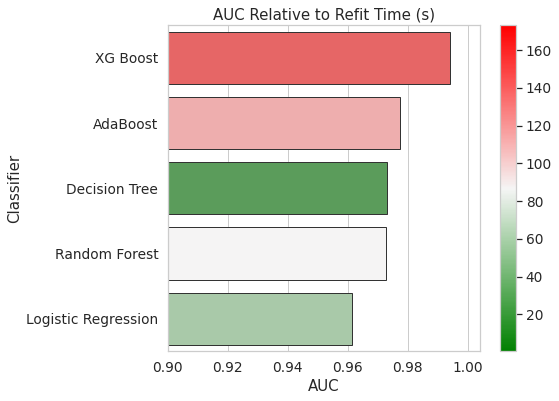

In [ ]:
greenToRed = LinearSegmentedColormap.from_list('', ['green', 'whitesmoke', 'red'])
cm.register_cmap('green_to_red', greenToRed)

normRTs = plt.Normalize(results['Refit Time'].min(), results['Refit Time'].max())
smRTs = plt.cm.ScalarMappable(cmap = 'green_to_red', norm = normRTs)

ax = sns.barplot(y = 'Classifier', 
                 x = 'AUC', 
                 hue = 'Refit Time', 
                 dodge = False, 
                 palette = 'green_to_red', 
                 edgecolor = '.2', 
                 data = results)

ax.get_legend().remove()
ax.figure.colorbar(smRTs)
ax.set(title = 'AUC Relative to Refit Time (s)')
ax.set(xlim = (math.floor(results.AUC.min() * 10) * 10/100, 
               results.AUC.max() * 1.01))

plt.show()

##### AUC Comparison

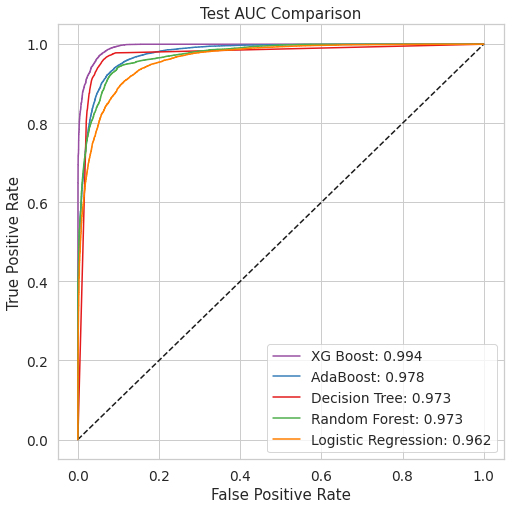

In [ ]:
# defining a custom function for reuse later
def Custom_ROC_Plot (results, X_test, y_test, title, figwidth = 8, figheight = 8):

    fig, ax = plt.subplots(figsize = (figwidth, figheight))

    ax.plot(ax.get_xlim(), ax.get_ylim(), ls = '--', c = 'k')
    ax.set(title = title)

    for i in results.index:
        plot_roc_curve(models[i], 
                       X_test, 
                       y_test, 
                       color = cm.Set1(i), 
                       label = results.loc[i, 'Classifier'] + ': {:.3f}'.format(results.loc[i, 'AUC']),  
                       ax = ax)
        
    return([fig, ax])

fig, ax = Custom_ROC_Plot(results, X_test, y_test, title = 'Test AUC Comparison')

##### Confusion Matrix

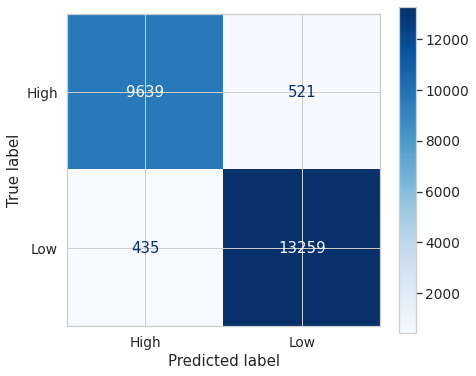

In [ ]:
plot_confusion_matrix(models[best_index], 
                      X_test, 
                      y_test,
                      cmap = plt.cm.Blues,
                      values_format = 'd')

In [ ]:
print(classification_report(y_test, preds[best_index], digits = 3))


              precision    recall  f1-score   support

        High      0.957     0.949     0.953     10160
         Low      0.962     0.968     0.965     13694

    accuracy                          0.960     23854
   macro avg      0.960     0.958     0.959     23854
weighted avg      0.960     0.960     0.960     23854



In [ ]:
TP = 9639  # True Positive
TN = 13259 # True Negative
FP = 521  # False Positive
FN = 435 # False Negative

test_metrics = pd.DataFrame({
    'Sensitivity': [TP/(TP+FN)], 
    'Specificity': [TN/(TN+FP)], 
    'Positive Predictive Value': [TP/(TP+FP)], 
    'Negative Predictive Value': [TN/(TN+FN)], 
    'F1 Score': [TP/(TP+.5*(FP+FN))], 
    'Accuracy': [(TP+TN)/(TP+TN+FP+FN)]})

test_metrics['Balanced Accuracy'] = np.mean([test_metrics.Sensitivity, test_metrics.Specificity])

round(test_metrics, 3)

,Sensitivity,Specificity,Positive Predictive Value,Negative Predictive Value,F1 Score,Accuracy,Balanced Accuracy
0,0.957,0.962,0.949,0.968,0.953,0.96,0.96


What was the accuracy?

0.960

What was the balanced accuracy?

0.958

What was the sensitivity score? 

0.957

What was the specificity score?

0.962 

##### Features Analysis 

<AxesSubplot:xlabel='importance', ylabel='feature'>

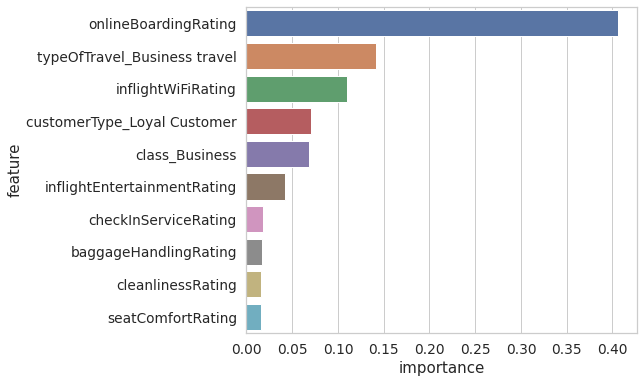

In [ ]:
# for models with feature importances
if hasattr(models[best_index].best_estimator_, 'feature_importances_'):
    var_imp = pd.DataFrame({
        'feature': X_test.columns, 
        'importance': models[best_index].best_estimator_.feature_importances_}).sort_values('importance', ascending = False)
# for models with coefficients (directional)
elif hasattr(models[best_index].best_estimator_, 'coef_'):
    var_imp = pd.DataFrame({
        'feature': X_test.columns, 
        'importance_abs': abs(models[best_index].best_estimator_.coef_[0]), 
        'importance': models[best_index].best_estimator_.coef_[0]}).sort_values('importance_abs', ascending = False)
    
sns.barplot(y = 'feature', 
            x = 'importance', 
            data = var_imp.head(10))

**Observations from XG Boost Model Output:**

As noted above, the XG Boost model (Extreme Gradient Boosting Decision Tree Model), performs best for our data set.
Compared to some of the other models we examined, it is a little more time intensive. 
If time is extremely important than a Decision Tree Model may actually work well for this data and is definitely less time-consuming.

The XG Boost Model peforms well on balanced accuracy, sensitivity, and specifcity, being above 95% for all three measures.

Looking at the important features from the model, a number of them are under the control of the airline and therefore could be targeted to try and increase overall statisfaction. We will examine the top 5 of these features here:
* Online Boarding Rating - the visualizations we did earlier indicated that this variable could be important in respect to the target variable. XG Boost picks up on this as the most important feature. The airline could certainly take action on its Online Boarding process. Improving the rating of this variable for customers looks like it has an important impact on the target variable.
* Type of Travel: Business - this feature also improved important for the model; the visualizations above showed that business travel generally results in higher ratings of the target variable. It seems like business travelers are more satisfied with this airline than personal travelers and therefore the airline may want to target its marekting campaigns to business travelers as many seem to enjoy this airline for business travel.
* In-Flight WiFi Rating - this feature is the 3rd most important for the model; again this is within the control of the airline and therefore improving ratings here could have a good effect on the overall satisfaction of customers.
* Customer Type: Loyal Customer - the model identifies the presence of loyal customers as having a key impact in the accuracy of the model. This may be a little harder for the airline to control, while generally it would favor loyal customers as we would expect these customers to be more satisfied with the airline to retain a loyal status, this is likely based off of the perks that come along with being a loyal customer and therefore may drive costs for the airlines.
* Class: Business - the presence of this feature is also important for the accuracy of the model. As mentioned above, this airline seems to do well with business travelers and therefore it may want to consider possible expansion of its business class and marketing campaigns to focus on business travelers who are looking for business class seating.

### Using SHAP to interpret Machine Learning Output in Greater Detail:

Information on how to interpret SHAP Plots can be found here:

https://www.analyticsvidhya.com/blog/2019/11/shapley-value-machine-learning-interpretability-game-theory/?utm_source=blog&utm_medium=6-python-libraries-interpret-machine-learning-models

Some useful information can also be found here:
https://evgenypogorelov.com/multiclass-xgb-shap.html

Shapley values correspond to how much each feature influences the movement of the prediction away from its average value.  Certain features will have a greater effect on moving the predicted value away from the average. SHAP attempts to make this clearer by analyzing this for individual observations and also examining this for the entirety of a feature.





In [ ]:
#Setting up SHAP values to build plots:
modelUsed = models[best_index].best_estimator_

# Assuming we are using XGBoost as need to use different SHAP function if not
explainerSHAP = shap.TreeExplainer(modelUsed)
shap_values = explainerSHAP.shap_values(X_train)


In [ ]:
# Setting value for pulling individual records from data set:
i = 15794

##### SHAP Provides the ability to analyze single observations:

In [ ]:
# Feature values for the above observation:
X_train.iloc[i]

gender_Female                     1.000000
gender_Male                       0.000000
customerType_Loyal Customer       1.000000
customerType_disloyal Customer    0.000000
typeOfTravel_Business travel      1.000000
typeOfTravel_Personal Travel      0.000000
class_Business                    1.000000
class_Eco                         0.000000
class_Eco Plus                    0.000000
age                               0.181818
flightDistance                    1.613037
inflightWiFiRating                0.000000
depArrConvenienceRating           0.000000
easeOnlineBookingRating          -0.500000
gateLocationRating                0.000000
foodDrinkRating                   1.000000
onlineBoardingRating              0.500000
seatComfortRating                 0.000000
inflightEntertainmentRating      -0.333333
onBoardServiceRating             -1.000000
legRoomRating                     0.000000
baggageHandlingRating            -0.500000
checkInServiceRating              2.000000
inflightSer

In [ ]:
# Pull out an observation from the training set to examine its SHAP values:

# Need to load JS visualisation in the notebook
shap.initjs()

shap.force_plot(explainerSHAP.expected_value, shap_values[i], features=X_train.iloc[i], feature_names=X_train.columns)

The blue segments and the corresponding features in the above graph show which variables moved the prediction in the negative direction.
Here the **negative** direction corresponds to a greater probability that the customer would have a **High Overall Satisfaction** rating.
The size of the blue segments for each feature also indicate how much of an effect the feature value had on the movement away from the average predicted value.

The red segments and the corresponding features in the above graph show which variables moved the prediction in the positive direction.
Here the **positive** direction corresponds to a greater probability that the customer would have a **Low Overall Satisfaction** (i.e. they are more likely to be neutral of have low overall satisfaction)
The size of the red segments for each feature also indicates how much of an effect the feature value had on the movement away from the average predicted value.

For our data set the average value using SHAP was 0.02106.

##### SHAP also provides the ability to examine features in total:

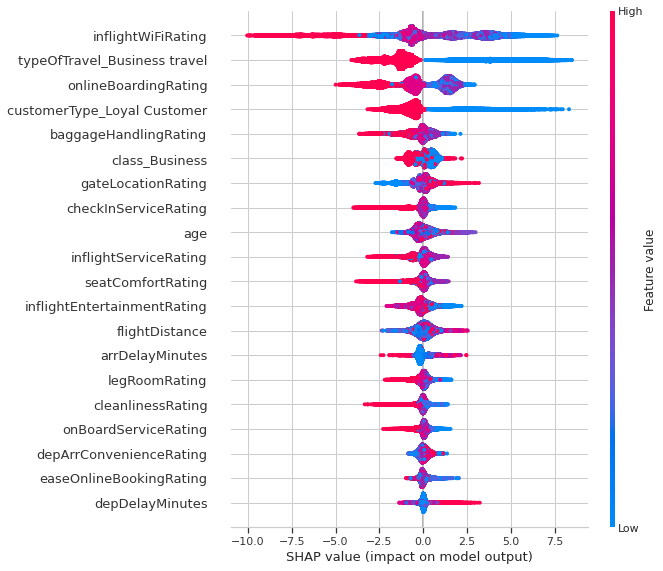

In [ ]:
# Building a SHAP Plot for examining all of the features:

# Need to load JS visualisation in the notebook
shap.initjs()

shap.summary_plot(shap_values, features=X_train, feature_names=X_train.columns)


The negative SHAP value corresponds to the High Overall Satisfaction class and the positive SHAP value corresponds to the Low Overall Satisfaction Class.
Therefore, based on the above, a high feature value on In-Flight WiFi Rating is more likely to correspond with a High Overall Satisfaction.
This graph does not show causal relationships and rather demonstrates certain dependencies and correlations that occur within the data set.

invalid value encountered in true_divide
invalid value encountered in true_divide


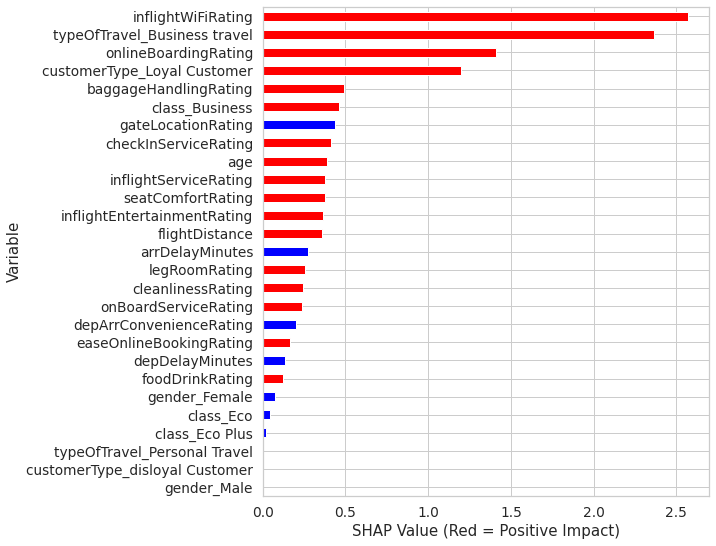

In [ ]:
# Displaying a graph that is better at discerning relative impacts and direction:

def ABS_SHAP(df_shap,df):
    #import matplotlib as plt
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']<0,'red','blue')
    
    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(8,9),legend=False)
    ax.set_xlabel("SHAP Value (Red = Positive Impact)")
    
ABS_SHAP(shap_values,X_train)

The above chart shows the feature impact on the Shapley values. 

In-Flight WiFi Rating has the highest impact.
A high rating on the In-Flight WiFi is more likely to lead to a high overall satisfaction (red color of the bar).
Similarly, if the type of travel is Business, the outcome is more likely to be high overall satisfaction.

Considering another feature, a high Gate Location rating actually corresponds to a lower likelihood that the customer will have a high overall satisfaction (blue color for the bar).

##### Feature Dependence can also be examined in SHAP

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


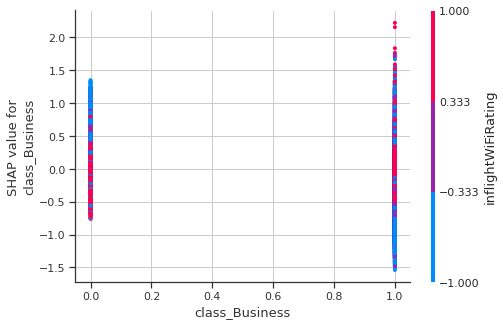

In [ ]:
# Building a SHAP Dependence Plot for examining certain features:

# Need to load JS visualisation in the notebook
shap.initjs()
shap.dependence_plot('class_Business', shap_values, X_train, interaction_index='inflightWiFiRating')
# If you do not specify an interaction_index, then it automatically chooses the strongest one
